In [2]:
import os
os.chdir("c:/Personal/AI/Projects")

In [3]:
from src.data_processing.data_augmentation import Affine_Transformation
from src.utils.utils import load_config


In [4]:
import numpy as np
import pandas as pd
import glob
import os
import torch 
import random
import re

from torch.utils.data import DataLoader,Dataset

In [5]:
ROWS_PER_FRAME = 543
MAX_LEN = 384

In [6]:
# Initial landmark points
face_landmarks = dict (
    silhouette=[
        10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
        397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
        172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109],

    lipsUpperOuter=[61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291],
    lipsLowerOuter=[146, 91, 181, 84, 17, 314, 405, 321, 375],
    lipsUpperInner=[78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308],
    lipsLowerInner=[95, 88, 178, 87, 14, 317, 402, 318, 324],

    rightEyeUpper0=[246, 161, 160, 159, 158, 157, 173],
    rightEyeLower0=[33, 7, 163, 144, 145, 153, 154, 155, 133],
    rightEyeUpper1=[247, 30, 29, 27, 28, 56, 190],
    rightEyeLower1=[130, 25, 110, 24, 23, 22, 26, 112, 243],
    rightEyeUpper2=[113, 225, 224, 223, 222, 221, 189],
    rightEyeLower2=[226, 31, 228, 229, 230, 231, 232, 233, 244],
    rightEyeLower3=[143, 111, 117, 118, 119, 120, 121, 128, 245],

    rightEyebrowUpper=[156, 70, 63, 105, 66, 107, 55, 193],
    rightEyebrowLower=[35, 124, 46, 53, 52, 65],

    rightEyeIris=[473, 474, 475, 476, 477],

    leftEyeUpper0=[466, 388, 387, 386, 385, 384, 398],
    leftEyeLower0=[263, 249, 390, 373, 374, 380, 381, 382, 362],
    leftEyeUpper1=[467, 260, 259, 257, 258, 286, 414],
    leftEyeLower1=[359, 255, 339, 254, 253, 252, 256, 341, 463],
    leftEyeUpper2=[342, 445, 444, 443, 442, 441, 413],
    leftEyeLower2=[446, 261, 448, 449, 450, 451, 452, 453, 464],
    leftEyeLower3=[372, 340, 346, 347, 348, 349, 350, 357, 465],

    leftEyebrowUpper=[383, 300, 293, 334, 296, 336, 285, 417],
    leftEyebrowLower=[265, 353, 276, 283, 282, 295],

    leftEyeIris=[468, 469, 470, 471, 472],

    midwayBetweenEyes=[168],

    noseTip=[1],
    noseBottom=[2],
    noseRightCorner=[98],
    noseLeftCorner=[327],

    rightCheek=[205],
    leftCheek=[425]
)


hand_landmarks = dict (
    thumb=[1, 2, 3, 4],
    indexFinger=[5, 6, 7, 8],
    middleFinger=[9, 10, 11, 12],
    ringFinger=[13, 14, 15, 16],
    pinky=[17, 18, 19, 20],
    palmBase=[0]
)

pose_landmarks = dict(
    leftArm=[12, 14, 16],
    rightArm=[11, 13, 15],
    body=[11, 23, 24, 12]
)

pose_start_index= 0
face_start_index = 33
left_start_index = 501
right_start_index = 522

l_hand_indexes = []
for keypoint_name in hand_landmarks:
    for index in hand_landmarks[keypoint_name]:
        l_hand_indexes.append(index + left_start_index)
l_hand_indexes = list(set(l_hand_indexes))
l_hand_indexes.sort()
l_hand_indexes = np.array(l_hand_indexes)

r_hand_indexes = []
for keypoint_name in hand_landmarks:
    for index in hand_landmarks[keypoint_name]:
        r_hand_indexes.append(index + right_start_index)
r_hand_indexes = list(set(r_hand_indexes))
r_hand_indexes.sort()
r_hand_indexes = np.array(r_hand_indexes)

In [7]:
r_hand_indexes.shape

(21,)

In [8]:
aug_param = {}
aug_param["angle"] = 5.0       # Reduced rotation to 5 degrees
aug_param["scale"] = 0.9       # Scale range closer to 1 (0.9 to 1.1 range)
aug_param["shift_x"] = 0.05    # Reduced horizontal shift to 5%
aug_param["shift_y"] = 0.05    # Reduced vertical shift to 5%
aug_param["angle_skew_x"] = 0.5 # Reduced skew to 0.5 degrees
aug_param["angle_skew_y"] = 0.5 # Reduced skew to 0.5 degrees

In [9]:
config =load_config("./configs/config.yaml")

In [10]:
config["aug_param"]

{'angle': 5.0,
 'scale': 0.9,
 'shift_x': 0.05,
 'shift_y': 0.05,
 'angle_skew_x': 0.5,
 'angle_skew_y': 0.5}

In [11]:
from src.data_processing.dataset import SignData

In [19]:


def take_all_landmarks_processing(full_landmarks, face_landmarks):
    midwayBetweenEyes = full_landmarks[:, 168]
    mean_lips = np.nanmean(midwayBetweenEyes, axis = 0, keepdims = True)
    full_landmarks = full_landmarks - mean_lips
    left_hand = full_landmarks[:, l_hand_indexes]
    right_hand = full_landmarks[:, r_hand_indexes]
    lips_indexes = face_landmarks["lipsUpperOuter"] + face_landmarks["lipsLowerOuter"] + face_landmarks["lipsUpperInner"] + face_landmarks["lipsLowerInner"]
    lips = full_landmarks[:, lips_indexes]
    landmark_dict = dict(left_hand=left_hand, right_hand=right_hand, lips=lips)
    return landmark_dict

def augmentation(landmarks, aug_params):
    angle_rotation = random.gauss(0, aug_params["angle"]/2)
    scale = random.gauss(1, aug_params["scale"]/2)
    translation_x = random.gauss(0, aug_params["shift_x"]/2)
    translation_y = random.gauss(0, aug_params["shift_y"]/2)
    shift_x = random.gauss(0, aug_params["shift_x"]/2)
    shift_y = random.gauss(0, aug_params["shift_y"]/2)
    angle_skew_x = random.gauss(0, aug_params["angle_skew_x"]/2)
    angle_skew_y = random.gauss(0, aug_params["angle_skew_y"]/2)
    Affine = Affine_Transformation()
    Affine.random_rotation(-angle_rotation, angle_rotation)
    Affine.scaling(scale)
    Affine.translation(-translation_x, translation_y)
    Affine.skew_x_degree(angle_skew_x)
    Affine.skew_y_degree(angle_skew_y)
    aug_landmarks_z = landmarks[:, :, 2][:, :, None]
    aug_landmarks = landmarks[:, :, :2]
    aug_landmarks = Affine.transform(aug_landmarks)
    aug_landmarks = np.concatenate((aug_landmarks, aug_landmarks_z), axis=2)
    aug_landmarks = aug_landmarks + landmarks[:, 0][:, None]
    aug_landmarks = aug_landmarks.astype(np.float32)
    return aug_landmarks

In [20]:
actions = config["labels"]["actions"]

path = config["paths"]["data_dir"] 

ans = []
for action in actions:
    seq = []
    for sequence in range(10):
        seq.append(glob.glob(f"{path}/{action}/{sequence}/**.npy" ))
        
    ans.append(seq)
len(ans[0][0])

30

In [16]:
from sklearn.model_selection import train_test_split

In [15]:
new_ans = []
for a in ans:
    for i in range(10):
        arr = sorted(a[i], key = lambda x: int(re.search(r'\\(\d+)\.npy$',x).group(1)))
    
        new_ans.append(arr)
# np.array(new_ans).shape
new_ans

[['data/raw/Hello/0\\0.npy',
  'data/raw/Hello/0\\1.npy',
  'data/raw/Hello/0\\2.npy',
  'data/raw/Hello/0\\3.npy',
  'data/raw/Hello/0\\4.npy',
  'data/raw/Hello/0\\5.npy',
  'data/raw/Hello/0\\6.npy',
  'data/raw/Hello/0\\7.npy',
  'data/raw/Hello/0\\8.npy',
  'data/raw/Hello/0\\9.npy',
  'data/raw/Hello/0\\10.npy',
  'data/raw/Hello/0\\11.npy',
  'data/raw/Hello/0\\12.npy',
  'data/raw/Hello/0\\13.npy',
  'data/raw/Hello/0\\14.npy',
  'data/raw/Hello/0\\15.npy',
  'data/raw/Hello/0\\16.npy',
  'data/raw/Hello/0\\17.npy',
  'data/raw/Hello/0\\18.npy',
  'data/raw/Hello/0\\19.npy',
  'data/raw/Hello/0\\20.npy',
  'data/raw/Hello/0\\21.npy',
  'data/raw/Hello/0\\22.npy',
  'data/raw/Hello/0\\23.npy',
  'data/raw/Hello/0\\24.npy',
  'data/raw/Hello/0\\25.npy',
  'data/raw/Hello/0\\26.npy',
  'data/raw/Hello/0\\27.npy',
  'data/raw/Hello/0\\28.npy',
  'data/raw/Hello/0\\29.npy'],
 ['data/raw/Hello/1\\0.npy',
  'data/raw/Hello/1\\1.npy',
  'data/raw/Hello/1\\2.npy',
  'data/raw/Hello/1\\3

In [16]:
train_videos, test_videos  = train_test_split(
    new_ans, test_size=0.2, random_state=42
)

In [210]:
label_map = {label: num for num, label in enumerate(actions)}
label_map

class SignData(Dataset):
    def __init__(self, path, label_map,frame_drop = 0.0 ,mode = "train", transform = None):
        super().__init__()
        self.path = path
        self.label_map = label_map
        self.mode = mode
        self.transform = transform
        self.dict = ["left_hand", "right_hand", "lips"] 
        self.frame_drop = frame_drop

    def __len__(self):
        return len(self.path)

    def apply_frame_drop(self, data, frame_drop):
        """
        Input:
        - data: numpy array of shape (T, P, 2), where T is the number of frames and P is the number of points.
        - frame_drop: float, percentage of frames to randomly drop.

        Output:
        - data: numpy array with frames dropped based on the given percentage.

        Description: Randomly drops frames from the data based on the specified frame drop percentage.
        """
        if frame_drop > 0.0:
            drop_mask = np.random.random(len(data)) >= frame_drop
            dropped_data = data[drop_mask]

            if len(dropped_data) >= 2:
                data = dropped_data
        return data

    def process_data(self, landmark_dict, aug_param= None, frame_drop = 0.0):
        if aug_param:
            landmark_dict["left_hand"] = augmentation(landmark_dict["left_hand"], aug_param)
            landmark_dict["right_hand"] = augmentation(landmark_dict["right_hand"], aug_param)
            landmark_dict["lips"] = augmentation(landmark_dict["lips"], aug_param)
        
            # Concatenate landmark data from all parts
        landmark = np.concatenate([landmark_dict[key] for key in self.dict], axis=1)
        landmark = self.apply_frame_drop(landmark, frame_drop)
        
        # Select only x, y coordinates
        landmark = landmark[:, :, :2]
        
        # Convert to tensor
        landmark = torch.tensor(landmark)
        
        # Normalize the data
        landmark = landmark - landmark[~torch.isnan(landmark)].mean(0, keepdims=True)
        landmark = landmark / landmark[~torch.isnan(landmark)].std(0, keepdims=True)
        
        # Handle NaN values
        landmark[torch.isnan(landmark)] = 0.0  # TxPx2
        landmark = torch.reshape(landmark, (landmark.shape[0], -1))

        # Permute to change shape
        landmark = torch.permute(landmark, (1, 0))  # 2P x T

        return landmark

    def __getitem__(self, idx):
        videos = self.path[idx]
        

        if self.mode == "train" or self.mode == "valid":
            landmarks = []
            for video in videos:
                landmark = np.load(video)
                landmarks.append(landmark)
            
                label_string = videos[0].replace("\\","/").split("/")[2]   
                label = self.label_map[label_string]

            landmarks = np.array(landmarks).reshape(-1, 543, 3)
            landmark_dict = take_all_landmarks_processing(landmarks, config["landmarks"]["face_landmarks"])

            landmark = self.process_data(landmark_dict, self.transform, frame_drop= self.frame_drop)
            
            landmark = torch.tensor(landmark, dtype=torch.float32)
            label = torch.tensor(label, dtype = torch.long)
            return landmark, label    

new_path = glob.glob(path+"/**/**/**.npy")
train_dataset = SignData(path= train_videos,label_map=label_map, mode = "train", transform= config["aug_param"])
valid_dataset = SignData(path= test_videos,label_map=label_map, mode = "valid")

In [212]:
train_data_loader = DataLoader(train_dataset, shuffle= True, batch_size = 4, num_workers = 0)
valid_data_loader = DataLoader(valid_dataset, shuffle= False, batch_size = 2, num_workers = 0)


In [213]:
iter_data = iter(train_data_loader)
a,b = next(iter_data)

C:\Users\thoma\AppData\Local\Temp\ipykernel_10900\1677806290.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmark = torch.tensor(landmark, dtype=torch.float32)


In [214]:
a.shape

torch.Size([4, 164, 30])

In [13]:
import torch.nn as nn

class ECA(nn.Module):
    def __init__(self, kernel_size=5):
        """
        Input:
        - kernel_size: int, size of the convolution kernel (default is 5).

        Output:
        - Initializes an ECA block for adaptive channel attention.

        Description: Implements an Efficient Channel Attention (ECA) block that enhances the representation 
                     of the input tensor by applying a 1D convolution followed by a sigmoid activation.
        """
        super(ECA, self).__init__()
        self.conv = nn.Conv1d(192, 1, kernel_size=kernel_size, stride=1, padding=kernel_size // 2, bias=False)
    
    def forward(self, inputs):
        """
        Input:
        - inputs: tensor of shape [B, C, T], where B is the batch size, C is the number of channels, 
                  and T is the sequence length.

        Output:
        - Tensor with the same shape as inputs after applying ECA.

        Description: Computes the channel-wise attention using global average pooling, applies the 
                     convolution, and scales the input tensor with the attention weights.
        """
        nn = inputs.mean(dim=-1, keepdim=True)
        nn = self.conv(nn)
        nn = torch.sigmoid(nn)
        return inputs * nn

class CausalDWConv1D(nn.Module):
    def __init__(self, in_channels, kernel_size=17, dilation_rate=1, padding='causal'):
        """
        Input:
        - in_channels: int, number of input channels.
        - kernel_size: int, size of the convolution kernel (default is 17).
        - dilation_rate: int, dilation rate for the convolution (default is 1).
        - padding: str, type of padding to use (default is 'causal').

        Output:
        - Initializes a causal depthwise convolutional layer.

        Description: Implements a causal depthwise convolutional layer to prevent information leakage 
                     from future time steps in sequential data.
        """
        super(CausalDWConv1D, self).__init__()
        self.conv = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, dilation=dilation_rate, padding=0, bias=False)
        self.pad = nn.ConstantPad1d((dilation_rate * (kernel_size - 1), 0), 0)

    def forward(self, x):
        """
        Input:
        - x: tensor of shape [B, C, T], where B is the batch size, C is the number of channels, 
              and T is the sequence length.

        Output:
        - Processed tensor after causal convolution.

        Description: Applies causal padding and depthwise convolution to the input tensor.
        """
        x = self.pad(x)
        x = self.conv(x)
        return x

class Conv1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=17, dilation_rate=1, drop_rate=0.2):
        """
        Input:
        - in_channels: int, number of input channels.
        - out_channels: int, number of output channels.
        - kernel_size: int, size of the convolution kernel (default is 17).
        - dilation_rate: int, dilation rate for the convolution (default is 1).
        - drop_rate: float, dropout rate (default is 0.2).

        Output:
        - Initializes a 1D convolutional block.

        Description: Combines convolution, batch normalization, ReLU activation, 
                     Efficient Channel Attention (ECA), and dropout.
        """
        super(Conv1DBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2, dilation=dilation_rate)
        self.bn = nn.BatchNorm1d(out_channels)
        self.drop = nn.Dropout(drop_rate)
        self.eca = ECA()

    def forward(self, x):
        """
        Input:
        - x: tensor of shape [B, C, T].

        Output:
        - Processed tensor after passing through the convolutional block.

        Description: Applies convolution, batch normalization, activation, ECA, and dropout to the input tensor.
        """
        x = self.conv(x)
        x = self.bn(x)
        x = torch.relu(x)
        x = self.eca(x)
        x = self.drop(x)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.2):
        """
        Input:
        - dim: int, the dimensionality of the input tensor.
        - num_heads: int, number of attention heads.
        - dropout: float, dropout rate (default is 0.2).

        Output:
        - Initializes a multi-head self-attention layer.

        Description: Implements a multi-head self-attention mechanism with scaling and dropout.
        """
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Input:
        - x: tensor of shape [B, N, C], where B is the batch size, N is the number of tokens, 
              and C is the dimension.

        Output:
        - Processed tensor after applying multi-head self-attention.

        Description: Computes the attention scores, applies softmax, and performs 
                     the weighted sum of values, followed by a linear projection.
        """
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each has shape [B, num_heads, N, head_dim]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, expand_ratio=4, dropout=0.2):
        """
        Input:
        - dim: int, the dimensionality of the input tensor.
        - num_heads: int, number of attention heads.
        - expand_ratio: int, ratio for expanding the dimensionality in the feed-forward network (default is 4).
        - dropout: float, dropout rate (default is 0.2).

        Output:
        - Initializes a transformer block.

        Description: Combines multi-head self-attention and a feed-forward network with layer normalization.
        """
        super(TransformerBlock, self).__init__()
        self.attn = MultiHeadSelfAttention(dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * expand_ratio),
            nn.ReLU(),
            nn.Linear(dim * expand_ratio, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        Input:
        - x: tensor of shape [B, N, C].

        Output:
        - Processed tensor after passing through the transformer block.

        Description: Applies self-attention and feed-forward layers with residual connections and normalization.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

class CNN1DTransformer(nn.Module):
    def __init__(self, num_classes, seq_len=103, dim=192, num_heads=4, dropout=0.2):
        """
        Input:
        - num_classes: int, number of output classes for classification.
        - seq_len: int, length of the input sequences (default is 103).
        - dim: int, dimensionality of the feature space (default is 192).
        - num_heads: int, number of attention heads (default is 4).
        - dropout: float, dropout rate (default is 0.2).

        Output:
        - Initializes a CNN-Transformer model for sequence classification.

        Description: Combines several convolutional blocks followed by a transformer block for 
                     processing sequential data, concluding with a linear classification layer.
        """
        super(CNN1DTransformer, self).__init__()

        self.conv1 = Conv1DBlock(164, dim, kernel_size=17, drop_rate=dropout)
        self.conv2 = Conv1DBlock(dim, dim, kernel_size=17, drop_rate=dropout)
        self.conv3 = Conv1DBlock(dim, dim, kernel_size=17, drop_rate=dropout)

        self.transformer = TransformerBlock(dim=dim, num_heads=num_heads, dropout=dropout)

        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        """
        Input:
        - x: tensor of shape [batch_size, 164, seq_len].

        Output:
        - Tensor of shape [batch_size, num_classes] representing class scores.

        Description: Processes the input through convolutional layers, 
                     transformer block, and a final classification layer.
        """
        # Input shape: [batch_size, 164, seq_len]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Permute to [batch_size, seq_len, dim] for the Transformer
        x = x.permute(0, 2, 1)

        x = self.transformer(x)

        # Global average pooling
        x = x.mean(dim=1)

        # Final classification layer
        x = self.fc(x)
        return x

# Example usage
model = CNN1DTransformer(num_classes=7, seq_len=103, dim=192, num_heads=4)
input_data = torch.randn(1, 164, 30)  # Example input [batch_size, 164, seq_len]
output = model(input_data)
print(output.shape)  # Output shape should be [32, 32]
output


torch.Size([1, 7])


tensor([[ 0.1297, -0.2553,  0.0111, -0.0183, -0.1562, -0.0977,  0.1377]],
       grad_fn=<AddmmBackward0>)

In [216]:
def accuracy(pred, label):
    """
    Input:
    - pred: tensor of shape [B, num_classes], predicted class scores for B samples.
    - label: tensor of shape [B], true labels for B samples.

    Output:
    - acc: float, the accuracy percentage of the predictions.

    Description: 
    Calculates the accuracy of predicted class labels against true labels.
    The function uses `torch.argmax` to find the predicted class with the highest score for each sample.
    It then compares these predictions with the true labels to count the number of correct predictions.
    Finally, it computes the accuracy as the ratio of correct predictions to the total number of samples, 
    multiplied by 100 to express it as a percentage.
    """
    # Get the predicted labels by finding the index of the maximum value along dimension 1
    pred = torch.argmax(pred, dim=1)
    # Compare predicted labels with actual labels
    correct = (pred == label).sum().item()
    # Calculate accuracy
    acc = correct / len(label) * 100
    return acc

In [217]:
import time
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, data_loader, optimizer, loss_criteria, history_train):
    """
    Input:
    - model: the neural network model to train.
    - data_loader: DataLoader providing batches of training data and labels.
    - optimizer: the optimizer used for updating model parameters.
    - loss_criteria: the loss function to compute loss.
    - history_train: a dictionary to store training loss, accuracy, and time history.

    Output:
    - epoch_loss: average training loss for the epoch.
    - epoch_acc: average training accuracy for the epoch.
    - total_time: time taken to complete the epoch.

    Description:
    Trains the model for one epoch. It iterates over batches of data, calculates the predictions and loss,
    computes accuracy, and updates the model parameters. Training statistics are collected and returned.
    """
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    model.train()

    for batch_idx, (images, labels) in tqdm(enumerate(data_loader)):
        images = images.to(device)
        labels = labels.flatten().to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss = loss_criteria(pred, labels)
        epoch_loss.append(loss.item())

        acc = accuracy(pred, labels)
        epoch_acc.append(acc)

        loss.backward()
        optimizer.step()

    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = torch.mean(torch.tensor(epoch_loss, dtype=torch.float32))
    epoch_acc = torch.mean(torch.tensor(epoch_acc, dtype=torch.float32))

    history_train["loss"].append(epoch_loss)
    history_train["acc"].append(epoch_acc)
    history_train["time"].append(total_time)

    return epoch_loss, epoch_acc, total_time


def test_one_epoch(model, data_loader, loss_criteria, history_test,
                   model_name, best_val_acc):
    """
    Input:
    - model: the neural network model to evaluate.
    - data_loader: DataLoader providing batches of validation data and labels.
    - loss_criteria: the loss function to compute loss.
    - history_test: a dictionary to store validation loss, accuracy, and time history.
    - model_name: name for saving the model if validation accuracy improves.
    - best_val_acc: the best validation accuracy observed so far.

    Output:
    - epoch_loss: average validation loss for the epoch.
    - epoch_acc: average validation accuracy for the epoch.
    - total_time: time taken to complete the epoch.

    Description:
    Evaluates the model on validation data for one epoch. It calculates predictions and loss,
    computes accuracy, and checks if the current validation accuracy is the best. Validation statistics 
    are collected and returned.
    """
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    model.eval()

    for batch_idx, (images, labels) in tqdm(enumerate(data_loader)):
        images = images.to(device)
        labels = labels.flatten().to(device)

        with torch.inference_mode():
            pred = model(images)

        loss = loss_criteria(pred, labels)
        epoch_loss.append(loss.item())

        acc = accuracy(pred, labels)
        epoch_acc.append(acc)

    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = torch.mean(torch.tensor(epoch_loss, dtype=torch.float32))
    epoch_acc = torch.mean(torch.tensor(epoch_acc, dtype=torch.float32))

    history_test["loss"].append(epoch_loss)
    history_test["acc"].append(epoch_acc)
    history_test["time"].append(total_time)

    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), f"{model_name}.pth")

    return epoch_loss, epoch_acc, total_time


def run_model(model, train_loader, val_loader, loss_criteria, optimizer,
              history_train, history_test, best_val_acc, model_name, num_epochs):
    """
    Input:
    - model: the neural network model to train and evaluate.
    - train_loader: DataLoader providing batches of training data.
    - val_loader: DataLoader providing batches of validation data.
    - loss_criteria: the loss function to compute loss.
    - optimizer: the optimizer used for updating model parameters.
    - history_train: a dictionary to store training loss, accuracy, and time history.
    - history_test: a dictionary to store validation loss, accuracy, and time history.
    - best_val_acc: the best validation accuracy observed so far.
    - model_name: name for saving the model if validation accuracy improves.
    - num_epochs: total number of epochs to train the model.

    Output:
    - None: The function runs training and validation for specified epochs and logs results.

    Description:
    Manages the training and validation process over multiple epochs. It prints training and validation 
    statistics for each epoch, updating the history and saving the model if validation accuracy improves.
    """
    optimizer.zero_grad()
    for epoch in range(num_epochs):
        print("\nTraining........")
        train_loss, train_acc, train_time = train_one_epoch(model,
                                                            train_loader,
                                                            optimizer,
                                                            loss_criteria,
                                                            history_train)
        print(f"\nEpoch {epoch + 1}")
        print(f"Train Loss: {train_loss}")
        print(f"Train Accuracy: {train_acc}")
        print(f"Train Time: {train_time}")

        print("\nValidating........")
        val_loss, val_acc, val_time = test_one_epoch(model, val_loader,
                                                     loss_criteria,
                                                     history_test,
                                                     model_name,
                                                     best_val_acc)
        print(f"\nEpoch {epoch + 1}")
        print(f"Val Loss: {val_loss}")
        print(f"Val Accuracy: {val_acc}")
        print(f"Val Time: {val_time}")


In [ ]:
'''
    Description:
    This code initializes the model training process, including setting the device, defining the optimizer, 
    loss criteria, learning rate scheduler, and running the training and validation process across multiple folds.
'''

# Move the model to the specified device (CPU or GPU)
model.to(device)

# Initialize best validation accuracy to track improvements
best_val_acc = 0

# Define the number of epochs for training
epoch = 10

# Dictionaries to store training and validation history
history_train = {"loss": [], "acc": [], "time": []}
history_test = {"loss": [], "acc": [], "time": []}

# Define the loss criteria with label smoothing to help prevent overfitting
loss_criteria = nn.CrossEntropyLoss(label_smoothing=0.1)

# Initialize the optimizer; Adam is used here with a learning rate and weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Set up a learning rate scheduler that reduces the learning rate by a factor of 0.5 every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Loop over each fold for cross-validation
    
    # Run the model training and validation for the current fold
run_model(model, train_data_loader, valid_data_loader, loss_criteria,
            optimizer, history_train, history_test, best_val_acc, "./models/CNN1D", epoch)


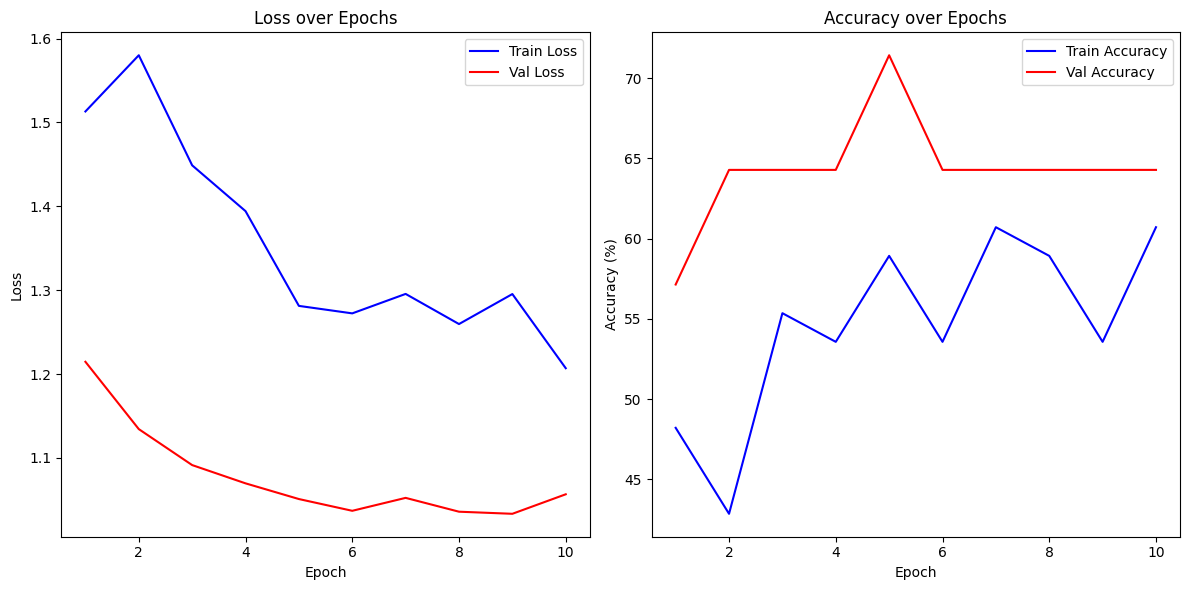

In [223]:
'''
    Description:
    This code visualizes the training and validation loss and accuracy metrics over the epochs 
    of the model training process.
'''
import matplotlib.pyplot as plt

# Define the range of epochs based on the length of training loss history
epochs = range(1, len(history_train["loss"]) + 1)

# Create a figure to plot Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, history_train["loss"], 'b', label='Train Loss')  # Plot training loss in blue
plt.plot(epochs, history_test["loss"], 'r', label='Val Loss')  # Plot validation loss in red
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.title('Loss over Epochs')  # Title of the plot
plt.legend()  # Display legend

# Plot Accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, history_train["acc"], 'b', label='Train Accuracy')  # Plot training accuracy in blue
plt.plot(epochs, history_test["acc"], 'r', label='Val Accuracy')  # Plot validation accuracy in red
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy (%)')  # Y-axis label
plt.title('Accuracy over Epochs')  # Title of the plot
plt.legend()  # Display legend

# Show plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the figure


In [14]:
import cv2
import mediapipe as mp

In [15]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmark(image, results, mp_drawing, mp_holistic):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                            mp_drawing.DrawingSpec(color = (80, 110, 10), thickness = 1, circle_radius = 1),
                            mp_drawing.DrawingSpec(color = (80, 256, 121), thickness = 1, circle_radius = 1)    )
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [16]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    res = res.squeeze(0) 
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob.item()*100), 90+num*40), colors[num % len(colors)], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [17]:
model_path = "./models/CNN1D.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [33]:
import cv2
import numpy as np
import mediapipe as mp
import torch

mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

sequence = []
sentence = []
predictions = torch.tensor([], dtype=torch.int32)
threshold = 0.5

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        model.eval()  # Đặt mô hình ở chế độ đánh giá

        # Đọc frame từ camera
        ret, frame = cap.read()
        if not ret:
            break

        # Nhận diện landmarks
        image, results = mediapipe_detection(frame, holistic)

        # Vẽ landmarks
        draw_landmark(image, results, mp_drawing, mp_holistic)

        # Xử lý keypoints
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Giữ lại 30 frame gần nhất

        if len(sequence) == 30:
            with torch.no_grad():
                landmarks = np.array(torch.tensor(sequence)).reshape(-1, 543, 3)
                landmark_dict = take_all_landmarks_processing(landmarks, config["landmarks"]["face_landmarks"])
                landmark = np.concatenate([landmark_dict[key] for key in ["left_hand", "right_hand", "lips"]], axis=1)

                # Chỉ lấy tọa độ (x, y)
                landmark = landmark[:, :, :2]

                # Chuyển thành tensor
                landmark = torch.tensor(landmark)

                # Chuẩn hóa dữ liệu
                landmark = landmark - landmark[~torch.isnan(landmark)].mean(0, keepdims=True)
                landmark = landmark / landmark[~torch.isnan(landmark)].std(0, keepdims=True)

                # Xử lý giá trị NaN
                landmark[torch.isnan(landmark)] = 0.0
                landmark = torch.reshape(landmark, (landmark.shape[0], -1))

                # Thay đổi hình dạng để phù hợp với mô hình
                landmark = torch.permute(landmark, (1, 0))
                landmark = torch.tensor(landmark, dtype=torch.float32)

                # Dự đoán
                res = model(landmark.unsqueeze(0))
                predicted_index = torch.argmax(res, dim=1).item()
                predicted_word = actions[predicted_index]  # Lấy từ dự đoán

                # Kiểm tra điều kiện để thêm từ vào câu
                if len(sentence) == 0 or (predicted_word != sentence[-1] and res[0, predicted_index] > threshold):
                    sentence.append(predicted_word)

                # Giới hạn độ dài câu
                if len(sentence) > 5:
                    sentence.pop(0)

            # Hiển thị xác suất dự đoán
            image = prob_viz(res, actions, image, colors)

        # Vẽ hộp chữ trên màn hình
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Hiển thị kết quả
        cv2.imshow('OpenCV Feed', image)

        # Thoát khi nhấn 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


C:\Users\thoma\AppData\Local\Temp\ipykernel_8988\1336754328.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmark = torch.tensor(landmark, dtype=torch.float32)
